In [6]:
import pandas as pd
from pandas_gbq import read_gbq

project_id = "subscription-482017"

query = """
SELECT *
FROM `subscription-482017.subscription_analytics.customer_features`
"""

df = read_gbq(query, project_id=project_id)
df.head()


Downloading: 100%|██████████|


,customer_id,successful_payments,failed_payments,total_revenue,recency_days,customer_lifetime_days,plan_type,country,acquisition_channel,signup_device,churned,snapshot_date
0,C03584,3,0,30,-68,59,Basic,United States,Social Media,Desktop,1,2025-12-26
1,C00941,3,0,30,-67,59,Basic,United States,Organic Search,Tablet,1,2025-12-26
2,C00958,4,0,40,-93,89,Basic,Other,Email Campaign,Tablet,1,2025-12-26
3,C04222,4,0,40,-93,88,Basic,Nigeria,Organic Search,Desktop,1,2025-12-26
4,C07873,5,0,50,-93,119,Basic,Germany,Email Campaign,Mobile,1,2025-12-26


In [7]:
df.info()
df.isna().mean().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customer_id             801 non-null    object
 1   successful_payments     801 non-null    Int64 
 2   failed_payments         801 non-null    Int64 
 3   total_revenue           801 non-null    Int64 
 4   recency_days            801 non-null    Int64 
 5   customer_lifetime_days  801 non-null    Int64 
 6   plan_type               801 non-null    object
 7   country                 801 non-null    object
 8   acquisition_channel     801 non-null    object
 9   signup_device           801 non-null    object
 10  churned                 801 non-null    Int64 
 11  snapshot_date           801 non-null    dbdate
dtypes: Int64(6), dbdate(1), object(5)
memory usage: 79.9+ KB


,0
customer_id,0.0
successful_payments,0.0
failed_payments,0.0
total_revenue,0.0
recency_days,0.0
customer_lifetime_days,0.0
plan_type,0.0
country,0.0
acquisition_channel,0.0
signup_device,0.0


In [8]:
df["churned"].value_counts(normalize=True)


,proportion
churned,
0,0.685393
1,0.314607


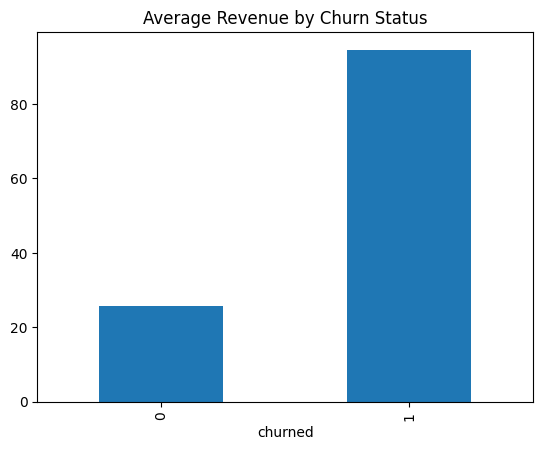

In [9]:
import matplotlib.pyplot as plt

df.groupby("churned")["total_revenue"].mean().plot(kind="bar")
plt.title("Average Revenue by Churn Status")
plt.show()


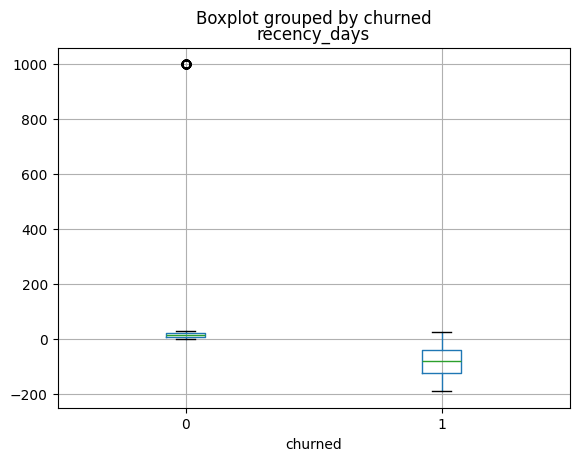

In [10]:
df.groupby("churned")["recency_days"].mean()
df.boxplot(column="recency_days", by="churned")
plt.show()


In [11]:
pd.crosstab(
    df["plan_type"],
    df["churned"],
    normalize="index"
)


churned,0,1
plan_type,,
Basic,0.710462,0.289538
Premium,0.680723,0.319277
Standard,0.642857,0.357143


In [12]:
df.groupby("acquisition_channel").agg(
    churn_rate=("churned", "mean"),
    avg_revenue=("total_revenue", "mean"),
    customers=("customer_id", "count")
).sort_values("churn_rate")


,churn_rate,avg_revenue,customers
acquisition_channel,,,
Email Campaign,0.265487,46.19469,113
Referral,0.265487,42.477876,113
Organic Search,0.318021,50.812721,283
Paid Ads,0.349282,49.617225,209
Social Media,0.349398,39.277108,83


In [13]:
numeric_cols = [
    "successful_payments",
    "failed_payments",
    "total_revenue",
    "recency_days",
    "customer_lifetime_days"
]

df[numeric_cols + ["churned"]].corr()["churned"].sort_values()


,churned
recency_days,-0.344059
failed_payments,0.188004
total_revenue,0.563845
successful_payments,0.794588
customer_lifetime_days,0.813707
churned,1.000000


In [14]:
import pandas as pd
from pandas_gbq import read_gbq

project_id = "subscription-482017"

query = """
SELECT *
FROM `subscription-482017.subscription_analytics.customer_features`
"""

df = read_gbq(query, project_id=project_id)


Downloading: 100%|██████████|


In [15]:
target = "churned"

categorical_features = [
    "plan_type",
    "country",
    "acquisition_channel",
    "signup_device"
]

numeric_features = [
    "successful_payments",
    "failed_payments",
    "total_revenue",
    "recency_days",
    "customer_lifetime_days"
]


In [16]:
df[target].value_counts(normalize=True)


,proportion
churned,
0,0.685393
1,0.314607


In [17]:
df = df.sort_values("recency_days")

split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]


In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [19]:
locals().keys()


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'pd', 'read_gbq', 'project_id', 'query', '_i2', '_i3', '_i4', 'LogisticRegression', 'model', '_i5', 'train_test_split', '_i6', 'df', '_6', '_i7', '_7', '_i8', '_8', '_i9', 'plt', '_i10', '_i11', '_11', '_i12', '_12', '_i13', 'numeric_cols', '_13', '_i14', '_i15', 'target', 'categorical_features', 'numeric_features', '_i16', '_16', '_i17', 'split_index', 'train_df', 'test_df', '_i18', 'OneHotEncoder', 'StandardScaler', 'ColumnTransformer', 'Pipeline', '_i19'])

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=["churned"])
y = df["churned"]

numeric_features = [
    "successful_payments",
    "failed_payments",
    "total_revenue",
    "recency_days",
    "customer_lifetime_days"
]

categorical_features = [
    "plan_type",
    "country",
    "acquisition_channel",
    "signup_device"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['successful_payments',
                                                   'failed_payments',
                                                   'total_revenue',
                                                   'recency_days',
                                                   'customer_lifetime_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['plan_type', 'country',
                                                   'acquisition_channel',
                                                   'signup_device'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [21]:
from sklearn.utils.validation import check_is_fitted
check_is_fitted(pipeline)


In [22]:
probs_all = pipeline.predict_proba(X)[:, 1]

df_all_scored = df.copy()
df_all_scored["churn_prob"] = probs_all

df_all_scored["risk_segment"] = pd.cut(
    df_all_scored["churn_prob"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)


In [23]:
 preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [24]:
probs = pipeline.predict_proba(X_test)[:, 1]

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)


In [25]:
probs_all = pipeline.predict_proba(X)[:, 1]

df_all_scored = df.copy()
df_all_scored["churn_prob"] = probs_all

df_all_scored["risk_segment"] = pd.cut(
    df_all_scored["churn_prob"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)


In [26]:
from sklearn.utils.validation import check_is_fitted

check_is_fitted(pipeline)


In [27]:
import pandas as pd

pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

pr_df.sort_values("recall", ascending=False).head(10)


,threshold,precision,recall
0,1.264095e-08,0.316770,1.0
1,1.534989e-08,0.318750,1.0
2,2.140784e-08,0.320755,1.0
3,3.421289e-08,0.322785,1.0
4,3.927685e-08,0.324841,1.0
5,5.309551e-08,0.326923,1.0
6,5.434065e-08,0.329032,1.0
7,5.503892e-08,0.331169,1.0
8,6.862050e-08,0.333333,1.0
9,6.954347e-08,0.335526,1.0


In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)


In [29]:
from sklearn.model_selection import train_test_split

X = df[numeric_features + categorical_features]
y = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)



In [30]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred_proba)


np.float64(0.9490196078431372)

In [31]:
print(classification_report(y_test, pipeline.predict(X_test)))


              precision    recall  f1-score   support

         0.0       0.88      0.97      0.93       110
         1.0       0.93      0.73      0.81        51

    accuracy                           0.89       161
   macro avg       0.90      0.85      0.87       161
weighted avg       0.90      0.89      0.89       161



In [32]:
feature_names = (
    pipeline.named_steps["preprocess"]
    .get_feature_names_out()
)

coefficients = pipeline.named_steps["model"].coef_[0]

importance = pd.Series(coefficients, index=feature_names).sort_values()
importance.tail(10)


,0
num__failed_payments,0.039482
cat__acquisition_channel_Paid Ads,0.273692
cat__country_United Kingdom,0.315507
cat__signup_device_Tablet,0.339020
cat__country_United States,0.369232
cat__plan_type_Basic,0.620225
cat__acquisition_channel_Social Media,0.725972
num__total_revenue,0.858831
num__successful_payments,2.924595
num__customer_lifetime_days,3.275810


In [33]:
df_scored = X_test.copy()
df_scored["churn_prob"] = probs
df_scored["actual_churn"] = y_test.values

df_scored["risk_segment"] = pd.cut(
    df_scored["churn_prob"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)


In [34]:
df_scored.columns.tolist()


['successful_payments',
 'failed_payments',
 'total_revenue',
 'recency_days',
 'customer_lifetime_days',
 'plan_type',
 'country',
 'acquisition_channel',
 'signup_device',
 'churn_prob',
 'actual_churn',
 'risk_segment']

In [35]:
segment_profile = (
    df_scored
    .groupby("risk_segment", observed=True)
    .agg(
        customers=("actual_churn", "count"),
        avg_revenue=("total_revenue", "mean"),
        avg_failed_payments=("failed_payments", "mean"),
        avg_lifetime=("customer_lifetime_days", "mean"),
        churn_rate=("actual_churn", "mean")
    )
    .reset_index()
)

segment_profile


,risk_segment,customers,avg_revenue,avg_failed_payments,avg_lifetime,churn_rate
0,Low,105,26.904762,0.12381,8.904762,0.085714
1,Medium,17,51.764706,0.0,30.411765,0.352941
2,High,39,99.871795,0.282051,117.589744,0.923077


In [36]:
from google.cloud import bigquery

client = bigquery.Client(project="subscription-482017")

table_id = "subscription-482017.subscription_analytics.churn_segments"

job = client.load_table_from_dataframe(
    df_all_scored[
        [
            "customer_id",
            "churn_prob",
            "risk_segment",
            "plan_type",
            "country",
            "acquisition_channel",
            "total_revenue",
            "customer_lifetime_days"
        ]
    ],
    table_id,
)

job.result()


LoadJob<project=subscription-482017, location=US, id=a0b272e2-b86b-42df-937c-218a2a5bb982>